# IACT DL3 data with Gammapy

## Introduction

This tutorial will show you how to work with IACT (Imaging Atmospheric Cherenkov Telescope) DL3 ("data level 3").

We will work with event data and instrument response functions (IRFs), mainly using [gammapy.data](http://docs.gammapy.org/en/latest/data/index.html) and [gammapy.irf](http://docs.gammapy.org/en/latest/irf/index.html).

TODO: briefly introduce HESS and this dataset (events are simulated for now).

The main class to load data is

* [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html)

The `DataStore` has two index tables:

* `DataStore.obs_table` ([gammapy.data.ObservationTable](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationTable.html)) to list and select available observations.
* `DataStore.hdu_table` ([gammapy.data.HDUIndexTable](http://docs.gammapy.org/en/latest/api/gammapy.data.HDUIndexTable.html)) to locate data for a given observation.

Data loading is done via the `DataStore.obs` method which returns a

* [gammapy.data.DataStoreObservation](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStoreObservation.html)

object, which on property access loads the data and IRFs and returns them as Gammapy objects.

We support the common IACT DL3 data formats: http://gamma-astro-data-formats.readthedocs.io/ .

In this tutorial we will use objects of these types:

* [gammapy.data.EventList](http://docs.gammapy.org/en/latest/api/gammapy.data.EventList.html)


* Load [gammapy.irf.EffectiveAreaTable2D](http://docs.gammapy.org/en/latest/api/gammapy.irf.EffectiveAreaTable2D.html), which has AEFF info for the whole field of view (FOV).
* For the given source offset in the FOV, slice out [gammapy.irf.EffectiveAreaTable](http://docs.gammapy.org/en/latest/api/gammapy.irf.EffectiveAreaTable.html)


* Load [gammapy.irf.EnergyDispersion2D](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDispersion2D.html), which has EDISP info for the whole FOV.
* For a given source offset in the FOV, slice out [gammapy.irf.EnergyDispersion](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDispersion.html)


* Load [gammapy.irf.EnergyDependentMultiGaussPSF](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDependentMultiGaussPSF.html), which has PSF info for the whole FOV using an analytical PSF model.
* For a given source offset in the FOV, slice out [gammapy.irf.EnergyDependentTablePSF](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDependentTablePSF.html).
* For a given energy or energy band, compute [gammapy.irf.TablePSF](http://docs.gammapy.org/en/latest/api/gammapy.irf.TablePSF.html).




## Setup

In [1]:
import matplotlib
import numpy

print('matplotlib : {}'.format(matplotlib.__version__))
print('numpy : {}'.format(numpy.__version__))

matplotlib : 1.5.3
numpy : 1.11.2


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# We only need to import the `DataStore`,
# all other data objects can be loaded via the data store.
from gammapy.data import DataStore
import astropy.units as u

## Data store

First, we need to select some observations for our spectral analysis. To this end we use the [data management](http://docs.gammapy.org/en/latest/data/dm.html) functionality in gammapy. The following example uses a simulated crab dataset in [gammapy-extra](https://github.com/gammapy/gammapy-extra). Ideally, we'd use crabs runs from the H.E.S.S. public data release, so if you have the released files just change the ``DATA_DIR`` variable to the corresponding folder.

In [4]:
data_store = DataStore.from_dir('$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2/')

In [5]:
data_store.info()


Data store summary info:
name: noname

HDU index table:
BASE_DIR: /home/kingj/Software/gammapy-extra/datasets/hess-crab4-hd-hap-prod2
Rows: 28
OBS_ID: 23523 -- 23592
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti', 'psf_3gauss', 'psf_king', 'psf_table']

Observation table:
Number of observations: 4


In [6]:
print(data_store.hdu_table.colnames)
data_store.hdu_table[:10][['OBS_ID', 'HDU_TYPE', 'HDU_CLASS', 'FILE_DIR', 'FILE_NAME', 'HDU_NAME']]

['OBS_ID', 'HDU_TYPE', 'HDU_CLASS', 'FILE_DIR', 'FILE_NAME', 'HDU_NAME', 'SIZE', 'MTIME', 'MD5']


OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME
int64,str6,str10,str26,str30,str12
23523,gti,gti,run023400-023599/run023523,hess_events_023523.fits.gz,GTI
23523,events,events,run023400-023599/run023523,hess_events_023523.fits.gz,EVENTS
23523,aeff,aeff_2d,run023400-023599/run023523,hess_aeff_2d_023523.fits.gz,AEFF_2D
23523,edisp,edisp_2d,run023400-023599/run023523,hess_edisp_2d_023523.fits.gz,EDISP_2D
23523,psf,psf_3gauss,run023400-023599/run023523,hess_psf_3gauss_023523.fits.gz,PSF_2D_GAUSS
23523,psf,psf_king,run023400-023599/run023523,hess_psf_king_023523.fits.gz,PSF_2D_KING
23523,psf,psf_table,run023400-023599/run023523,hess_psf_table_023523.fits.gz,PSF_2D_TABLE
23526,gti,gti,run023400-023599/run023526,hess_events_023526.fits.gz,GTI
23526,events,events,run023400-023599/run023526,hess_events_023526.fits.gz,EVENTS


## Observation selection

Select observations using the observation table

In [7]:
table = data_store.obs_table
print(table.colnames)
condition = [(table['OBJECT'] == 'Crab Nebula') & (table['LIVETIME'] * u.s > 20 * u.minute)]

subtable = table[condition]
print("Found {} runs".format(len(subtable)))
subtable[:10][['OBS_ID', 'OBJECT', 'TSTART', 'RA_PNT', 'DEC_PNT', 'LIVETIME']]

['ALT_PNT', 'AZ_PNT', 'DEADC', 'DEC_OBJ', 'DEC_PNT', 'EVENT_COUNT', 'EVENT_DEC_MEDIAN', 'EVENT_ENERGY_MEDIAN', 'EVENT_RA_MEDIAN', 'EVENT_TIME_MAX', 'EVENT_TIME_MIN', 'LIVETIME', 'MUONEFF', 'N_TELS', 'OBJECT', 'OBS_ID', 'ONTIME', 'QUALITY', 'RA_OBJ', 'RA_PNT', 'TELLIST', 'TSTART', 'TSTART_STR', 'TSTOP', 'TSTOP_STR', 'ZEN_PNT']
Found 4 runs


OBS_ID,OBJECT,TSTART,RA_PNT,DEC_PNT,LIVETIME
int64,str11,float32,float32,float32,float32
23523,Crab Nebula,53343.9,83.6333,21.5144,1581.74
23526,Crab Nebula,53344.0,83.6333,22.5144,1572.69
23559,Crab Nebula,53346.0,85.2533,22.0144,1578.12
23592,Crab Nebula,53347.9,82.0133,22.0144,1581.26


In [8]:
# In the following examples we'll just use this one observation
obs = data_store.obs(obs_id=23523)
print(obs)

Info for OBS_ID = 23523
- Start time: 53343.92
- Pointing pos: RA 83.63 deg / Dec 21.51 deg
- Observation duration: 1687.0 s
- Dead-time fraction: 6.240 %



## Events

Explore the `EventList`

EVENT_ID,OBS_ID,TIME,ENERGY,RA,DEC
,,,TeV,,
uint32,uint32,float64,float32,float32,float32
1,0,155469974.992,1.1156,83.5776,22.0612
2,0,155469977.838,0.518559,83.6413,22.0181
3,0,155469982.952,1.16163,83.5852,22.067
4,0,155469983.673,0.882421,83.6893,22.0391
5,0,155469987.893,1.64653,83.7514,22.1343
6,0,155470029.591,0.651381,83.6091,22.0128
7,0,155470030.699,1.90747,83.7433,21.9861
8,0,155470037.657,4.53406,83.5915,22.051


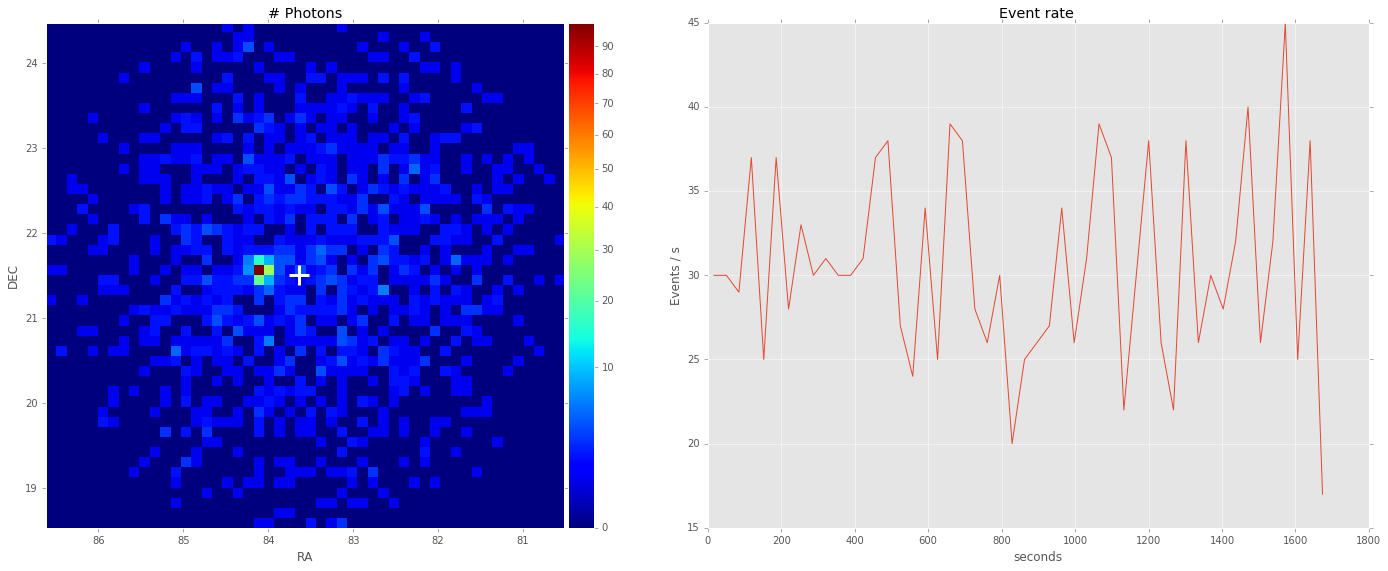

In [9]:
events = obs.events
events.peek()

events.table[:10][['EVENT_ID', 'OBS_ID', 'TIME', 'ENERGY', 'RA', 'DEC']]

## Effective area

Explore `EffectiveAreaTable2d` and `EffectiveAreaTable`

/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/astropy-1.3-py2.7-linux-x86_64.egg/astropy/units/quantity.py:960: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__itruediv__(other)
/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/matplotlib/axes/_base.py:1322: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


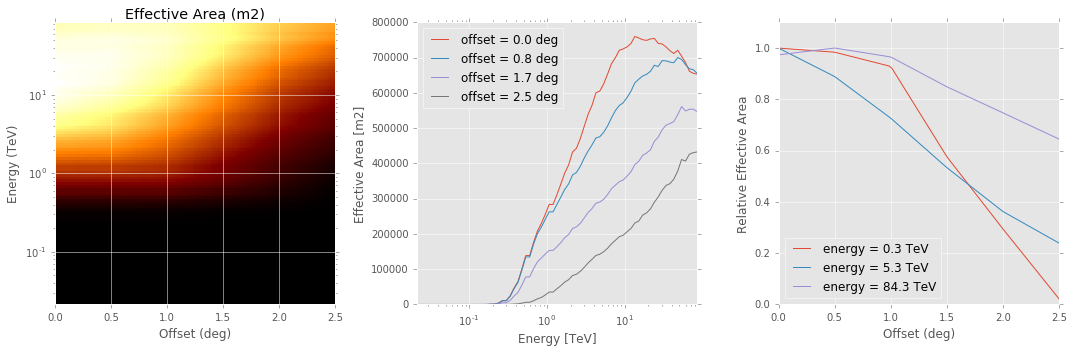

In [10]:
aeff = obs.aeff
aeff.peek()
print(aeff)

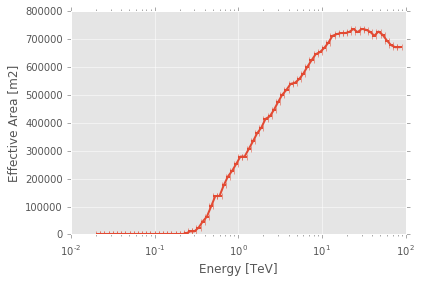

In [11]:
# Slice out effective area at a given offset
effarea = aeff.to_effective_area_table(offset = 0.5 * u.deg)
effarea.plot()

## Energy dispersion

Explore `EnergyDispersion2d` and `EnergyDispersion`

/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/astropy-1.3-py2.7-linux-x86_64.egg/astropy/units/quantity.py:951: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/matplotlib/axes/_base.py:1322: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))


EnergyDispersion2D
NDDataArray summary info
e_true         : size =    73, min =  0.021 TeV, max = 84.339 TeV
migra          : size =    31, min =  0.225, max =  1.725
offset         : size =     6, min =  0.000 deg, max =  2.500 deg
Data           : size = 13578, min =  0.000, max = 23.972



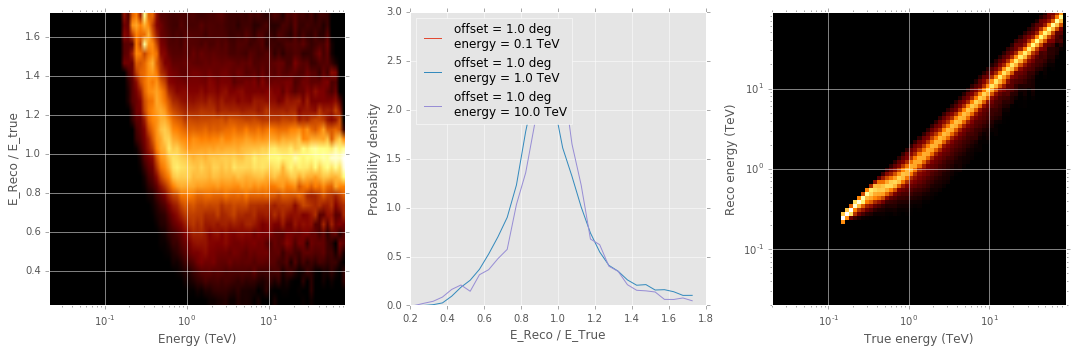

In [12]:
edisp = obs.edisp
edisp.peek()
print(edisp)

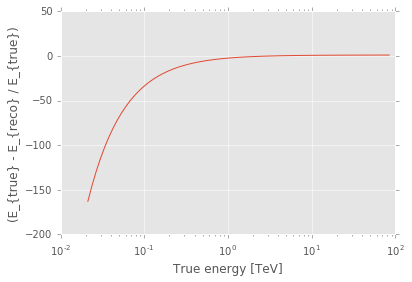

In [13]:
# Calculate energy dispersion matrix at a given offset

response_matrix = edisp.to_energy_dispersion(offset = 0.5 * u.deg)
response_matrix.plot_bias()

## PSF

TODO: examples for point spread function (PSF)

/home/kingj/Software/gammapy/gammapy/image/models/gauss.py:254: RuntimeWarning: invalid value encountered in true_divide
  self.norms /= self.integral


/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/matplotlib/colors.py:1199: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0


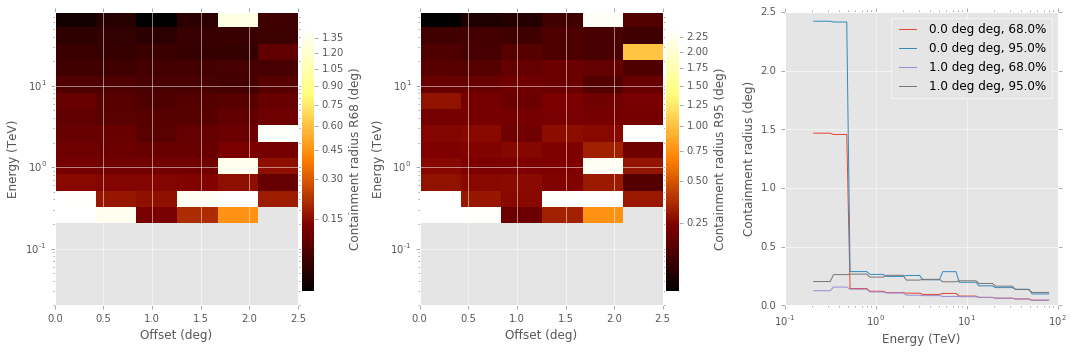

In [14]:
psf = obs.psf
psf.peek()
print(psf)

## Background model

TODO: example how to load and plot `gammapy.background.FOVBackgroundModel`

In [15]:
# TODO: this dataset doesn't have a background model yet.
# bkg = obs.bkg
# bkg.peek()
# print(bkg)

## Exercises

- TODO

In [16]:
# Start the exercises here!

## What next?

In this tutorial we have learned how to access and check IACT DL3 data.

Usually for a science analysis, if others have checked the data and IRF quality for you and you trust it's good, you don't need to do that.
Instead, you'll just run an analysis and look at higher-level results, like images or spectra.

Next you could do:
* image analysis
* spectral analysis
* cube analysis
* time analysis
* source detection